In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

### Code 6.13

In [2]:
from scipy.stats import norm, binom

# number of plants
N = 100

# initial heights
h0 = norm.rvs(loc=10, scale=2, size=N)

# assign treatment and fungus growth
treatment = np.zeros(N)
treatment[N//2:] = 1

# there is a 10% chance of fungus growth for the plants that have been treated; and 50% for those that haven't
fungus = binom.rvs(n=1, p=0.5 - 0.4 * treatment, loc=0, size=N)

# the mean height for plants without fungus is 10 + 5 = 15; for those with fungus: 10 + 2 = 12
h1 = h0 + norm.rvs(loc=5 - 3 * fungus, scale=1, size=N)

df = pd.DataFrame({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus})
df.describe([0.055, 0.945])

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,9.599872,13.809444,0.500000,0.310000
std,1.843656,2.709403,0.502519,0.464823
min,5.259717,6.413892,0.000000,0.000000
5.5%,6.575180,9.357213,0.000000,0.000000
50%,9.643318,13.887379,0.500000,0.000000
94.5%,12.693387,17.333465,1.000000,1.000000
max,13.293754,19.108121,1.000000,1.000000


## Causal Diagram of Fungal Growth Simulation

$$
    H_0 \rightarrow H_1 \leftarrow F \leftarrow T
$$

## Model 1 

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
     p      & \sim \text{LogNormal}(0, 0.25)
\end{align*}
$$

### Code 6.14

In [3]:
from scipy.stats import lognorm


# mu=0 and sd=0.25 corresponds to s=0.25 and scale=np.exp(mu)
sim_p = lognorm.rvs(s=0.25, scale=np.exp(0), size=10000)

df_sim_p = pd.DataFrame({'sim_p': sim_p})
df_sim_p.describe([0.055, 0.945]).round(2)

,sim_p
count,10000.00
mean,1.03
std,0.26
min,0.38
5.5%,0.67
50%,1.00
94.5%,1.49
max,3.10


<AxesSubplot:ylabel='Density'>

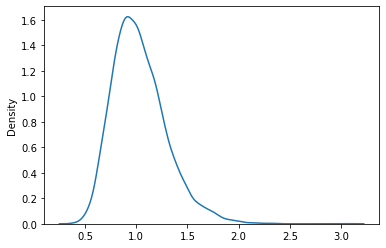

In [4]:
sns.kdeplot(sim_p)

### Code 6.15

In [5]:
with pm.Model() as m_6_6:
    p = pm.Lognormal('p', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_6 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


In [6]:
az.summary(trace_6_6, var_names=['p', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.423,0.021,1.389,1.456,0.000,0.000,7224.0,7224.0,7212.0,5474.0,1.0
sigma,2.030,0.146,1.796,2.248,0.002,0.001,6533.0,6375.0,6755.0,5620.0,1.0


## Model 2

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
    p       & = \alpha + \beta_T \cdot T_i + \beta_F \cdot F_i \\
    \alpha  & \sim \text{LogNormal}(0, 0.25) \\
    \beta_T & \sim N(0, 0.5) \\
    \beta_F & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 6.16

In [7]:
with pm.Model() as m_6_7:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    b_F = pm.Normal('b_F', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment'] + b_F * df['fungus']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_7 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_F, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


In [8]:
az.summary(trace_6_7, var_names=['a', 'b_T', 'b_F', 'sigma'], hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.538,0.026,1.495,1.579,0.000,0.000,4014.0,4013.0,4015.0,4407.0,1.0
b_T,-0.015,0.031,-0.065,0.031,0.000,0.000,4399.0,3684.0,4399.0,4627.0,1.0
b_F,-0.350,0.033,-0.402,-0.296,0.000,0.000,4520.0,4520.0,4516.0,4648.0,1.0
sigma,1.312,0.097,1.156,1.461,0.001,0.001,4896.0,4896.0,4886.0,4708.0,1.0


## Discussion

The treatment variable seems to have very small association with the final height $h_i$ although we explicity set up the simulation data to make it so. Fungus seems to have had a negative effect on the final height, which is as expected. The problem here is that `fungus` is a consequence of the `treatment` and by including both of these as predictors in the model, we are asking the question: if we know whether there is fungal growth or not, what is the influence of soil treatment?

This is what we get if we omit the `fungus` variable.

### Code 6.17

In [9]:
with pm.Model() as m_6_8:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_8 = pm.sample(2000, tune=2000)

az.summary(trace_6_8, var_names=['a', 'b_T', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.357,0.029,1.311,1.403,0.000,0.000,3866.0,3860.0,3868.0,4467.0,1.0
b_T,0.130,0.040,0.067,0.195,0.001,0.000,4021.0,4021.0,4029.0,4686.0,1.0
sigma,1.939,0.141,1.727,2.173,0.002,0.001,5174.0,5174.0,5048.0,4138.0,1.0


## Using the Causal Graph

Recall that the causal graph of the simulated data looks like this:
$$
    H_0 \rightarrow H_1 \leftarrow F \leftarrow T
$$
Conditioning on $F$ disconnects the path between $T$ and $H_1$ which then become independent. This is what we observed in the model where we included both $F$ and $T$ as predictors. The list of conditional independencies are:

* $H_0 \perp \!\!\! \perp  F$
* $H_0 \perp \!\!\! \perp  T$
* $T \perp \!\!\! \perp H_1 \vert F$

The situation that we faced in the model that included both $F$ and $T$ is described by $T \perp \!\!\! \perp H_1 \vert F$. 

Now, the statement $H_0 \perp \!\!\! \perp  F$ states that $H_0$ is independent of $F$ provided we do not condition on anything. If we do, in fact, condition on some other variable, say, $H_1$ then the variables $H_0$ and $F$ are no longer independent. Let's suppose that we consider all plants in the experiment that achieved a final height $H_1$ of 13 units. Of these, those that were infected by the fungus reached this height only because they had a high initial height $H_0$ to begin with. Those that weren't affected by the fungus most likely had a lower initial height. Thus conditioning on $H_1$ leads to a positive association between $H_0$ and $F$. Similarly, there is a positive association between $H_0$ and $T$ if we condition on $H_1$.

## When Fungal Growth Does Not Influence Growth

We are considering the situation depicted by the causal graph:
$$
    H_0 \rightarrow  H_1 \leftarrow {\large \bigcirc} \hspace{-6mm} M \rightarrow F \leftarrow T 
$$

Here $M$ represents any unobserved common cause that influences both the growth and fungus formation. 

In [10]:
from scipy.stats import bernoulli

# number of plants
N = 1000

# initial heights
h0 = norm.rvs(loc=10, scale=2, size=N)

# assign treatment and fungus growth
treatment = np.zeros(N)
treatment[N//2:] = 1

# Mositure: 50-50 chance of moisture
M = bernoulli.rvs(p=0.5, size=N)

# fungus is affected by both moisture and treatment
# Treatment | Moisture | Fungus Prob. |
# ----------|----------|--------------|
#         0 |        0 |         0.5  |
#         0 |        1 |         0.9  |
#         1 |        0 |         0.1  |
#         1 |        1 |         0.5  |
#######################################
fungus = binom.rvs(n=1, p=0.5 - 0.4 * treatment + 0.4 * M, loc=0, size=N)

# the mean height for plants without moisture is 10 + 5 = 15 units; for those with moisture: 10 + 8 = 18 units
h1 = h0 + norm.rvs(loc=5 + 3 * M, scale=1, size=N)

df_2 = pd.DataFrame({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus, 'M': M})
df_2.describe([0.055, 0.945])

,h0,h1,treatment,fungus,M
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,9.998544,16.440320,0.50000,0.495000,0.491000
std,2.032153,2.757513,0.50025,0.500225,0.500169
min,3.613361,6.112504,0.00000,0.000000,0.000000
5.5%,6.748911,12.040261,0.00000,0.000000,0.000000
50%,9.952974,16.570493,0.50000,0.000000,0.000000
94.5%,13.075685,20.776339,1.00000,1.000000,1.000000
max,16.724323,25.018437,1.00000,1.000000,1.000000


In [11]:
with pm.Model() as m_H_T:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df_2['treatment']
    mu = pm.Deterministic('mu', df_2['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df_2['h1'])
    
    trace_H_T = pm.sample(2000, tune=2000)

az.summary(trace_H_T, var_names=['a', 'b_T', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.6971946640108401, but should be close to 0.8. Try to increase the number of tuning steps.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.626,0.010,1.611,1.642,0.000,0.0,3778.0,3778.0,3778.0,4375.0,1.0
b_T,-0.013,0.014,-0.035,0.009,0.000,0.0,3725.0,3651.0,3729.0,4413.0,1.0
sigma,2.198,0.049,2.118,2.276,0.001,0.0,6304.0,6298.0,6292.0,4996.0,1.0


In [12]:
with pm.Model() as m_H_T_F:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    b_F = pm.Normal('b_F', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df_2['treatment'] + b_F * df_2['fungus']
    mu = pm.Deterministic('mu', df_2['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df_2['h1'])
    
    trace_H_T_F = pm.sample(2000, tune=2000)

az.summary(trace_H_T_F, var_names=['a', 'b_T', 'b_F', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_F, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.533,0.014,1.510,1.553,0.000,0.0,4222.0,4222.0,4228.0,4343.0,1.0
b_T,0.038,0.014,0.016,0.061,0.000,0.0,4819.0,4726.0,4824.0,5226.0,1.0
b_F,0.134,0.014,0.112,0.157,0.000,0.0,4685.0,4683.0,4687.0,4386.0,1.0
sigma,2.108,0.047,2.032,2.180,0.001,0.0,6054.0,6044.0,6085.0,5132.0,1.0
